In [33]:
import subprocess
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
RUN = 30010

In [35]:
# get stdout from a terminal command
def get_stdout(command):
    return subprocess.check_output(command, shell=True).decode('utf-8')

POD_TO_NODE = {}
def get_node_of_pod(podname):
    if podname in POD_TO_NODE:
        return POD_TO_NODE[podname]
    else:
        node = get_stdout("kubectl get pod " + podname + 
                   " -o jsonpath='{.spec.nodeName}'")
        POD_TO_NODE[podname] = node
        return node

In [36]:
logfilename = f"none_CPU_{RUN}"

with open(logfilename) as f:
    lines = f.readlines()
    
rows = []    
    
for line in lines:
    
    line_json = json.loads(line.strip())
    
    cpu_util = line_json["CPUUtilizations"]
    for podname in cpu_util.keys():
        if podname == "utils":
            continue
        rows.append({
            "time": float(line_json["time"])/10**9,
            "podname": podname,
            "service": "-".join(podname.split("-")[:-1]),
            "node": get_node_of_pod(podname),
            "cpu": float(cpu_util[podname]),
        })
        
df = pd.DataFrame(rows)
df["time"] = df["time"] - df["time"].min()
# df = df[df["time"] <= 30]

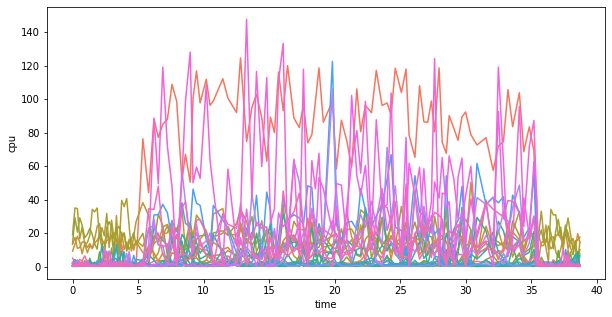

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.lineplot(ax=ax, data=df, x="time", y="cpu", hue="podname")

#remove legend from ax
ax.get_legend().remove()

In [46]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["podname", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,node,time,cpu
1,frontend-0,minikube,13.379263,71.678951
22,reservation-1,minikube-m02,13.379263,42.808955
17,profile-0,minikube-m04,13.379263,22.963966
5,hostagent-node2,minikube-m03,13.379263,20.441966
23,search-0,minikube-m02,13.379263,18.067761
19,rate-1,minikube-m04,13.379263,17.814144
6,hostagent-node3,minikube-m04,13.379263,17.515135
3,hostagent-node0,minikube,13.379263,16.828941
21,reservation-0,minikube-m03,13.379263,14.563242
4,hostagent-node1,minikube-m02,13.379263,12.886407


In [50]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["podname", "service", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped = df_grouped.sort_values("service", ascending=False)
df_grouped = df_grouped[["podname", "service", "node", "cpu"]].loc[(df_grouped["service"] == "reservation") | (df_grouped["service"] == "rate") | (df_grouped["service"] == "search")]
df_grouped["node"] = df_grouped["node"].apply(lambda x: int(x[-1]) - 1)
df_grouped = df_grouped.sort_values("node", ascending=True)
df_grouped

,podname,service,node,cpu
23,search-0,search,1,18.067761
22,reservation-1,reservation,1,42.808955
21,reservation-0,reservation,2,14.563242
18,rate-0,rate,2,2.043481
19,rate-1,rate,3,17.814144


In [39]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["node", "podname"]).mean()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

time        cpu
node         podname                                       
minikube     frontend-0                13.379263  71.678951
minikube-m02 reservation-1             13.379263  42.808955
minikube-m04 profile-0                 13.379263  22.963966
minikube-m03 hostagent-node2           13.379263  20.441966
minikube-m02 search-0                  13.379263  18.067761
minikube-m04 rate-1                    13.379263  17.814144
             hostagent-node3           13.379263  17.515135
minikube     hostagent-node0           13.379263  16.828941
minikube-m03 reservation-0             13.379263  14.563242
minikube-m02 hostagent-node1           13.379263  12.886407
minikube-m03 mongodb-profile-0         13.379263  10.644776
minikube-m04 recommendation-0          13.379263   9.143365
minikube-m03 geo-0                     13.379263   7.180518
minikube-m02 user-0                    13.379263   6.963146
minikube-m03 mongodb-rate-0            13.379263   6.618297
             consul-0                  13.379263   2.737004
             jaeger-0                  13.379263   2.453255
minikube     mongodb-recommendation-0  13.379263   2.202301
minikube-m03 rate-0                    13.379263   2.043481
minikube-m04 mongodb-reservation-0     13.379263   1.651271
             mongodb-geo-0             13.379263   1.479204
minikube-m03 mongodb-user-0            13.379263   1.422574
minikube     memcached-reserve-0       13.379263   0.948902
minikube-m02 memcached-profile-0       13.379263   0.880852
             memcached-rate-0          13.379263   0.581183

In [58]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index().groupby("node").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped = df_grouped.loc[df_grouped["node"] != "minikube"]
df_grouped["node"] = df_grouped["node"].apply(lambda x: int(x[-1]) - 1)
df_grouped[["node", "cpu"]]

,node,cpu
1,1,82.803857
2,2,71.041725
3,3,70.846249


In [57]:
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["node", "time"]).sum().reset_index().groupby("node").quantile(0.75).reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped = df_grouped.loc[df_grouped["node"] != "minikube"]
df_grouped["node"] = df_grouped["node"].apply(lambda x: int(x[-1]) - 1)
df_grouped[["node", "cpu"]]

,node,cpu
1,1,112.889755
2,2,89.870244
3,3,87.368003


In [42]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "service"]).mean().reset_index().groupby("service").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,service,time,cpu
1,frontend,15.315546,73.619073
3,hostagent,61.262185,67.107733
17,reservation,30.631093,60.467654
14,profile,15.315546,23.071439
15,rate,30.631093,19.640678
18,search,15.315546,18.558407
9,mongodb-profile,15.315546,10.801124
16,recommendation,15.315546,9.150480
2,geo,15.315546,7.503964
19,user,15.315546,6.979838


In [43]:
df_grouped = df[df["time"] < 1].groupby("podname").mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,time,cpu
5,hostagent-node2,0.45955,23.673647
6,hostagent-node3,0.45955,22.402840
3,hostagent-node0,0.45955,13.698980
4,hostagent-node1,0.45955,12.707680
0,consul-0,0.45955,3.919965
13,mongodb-rate-0,0.45955,1.786179
16,mongodb-user-0,0.45955,1.708969
11,mongodb-geo-0,0.45955,1.606467
15,mongodb-reservation-0,0.45955,1.526971
12,mongodb-profile-0,0.45955,1.502467
